In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


In [5]:
pristine_slab.get_tags()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [6]:
import torch
from nff.io.ase import AtomsBatch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [7]:
# set attributes
slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=system_settings["cutoff"],
    props={"energy": 0, "energy_grad": []},
    calculator=nff_surf_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

surface = SurfaceSystem(
    slab_batch, ads_positions, nff_surf_calc, system_settings=system_settings
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
ads coords is [ 7.871  7.941 18.87 ]
ads coords is [ 1.968  1.951 18.829]
ads coords is [ 1.968  0.146 18.782]
ads coords is [ 7.871  3.956 18.87 ]
ads coords is [ 1.968  5.936 18.829]
ads coords is [ 1.968  4.131 18.782]
ads coords is [ 3.936  7.941 18.87 ]
ads coords is [ 5.903  1.951 18.829]
ads coords is [ 5.903  0.146 18.782]
ads coords is [ 3.936  3.956 18.87 ]
ads coords is [ 5.903  5.936 18.829]
ads coords is [ 5.903  4.131 18.782]
ads coords is [ 1.968  7.026 18.806]
ads coords is [ 0.984  6.938 18.85 ]
ads coords is [ 5.903  7.026 18.806]
ads 

2024-03-28 15:56:50,611|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-03-28 15:56:50,611|INFO|number of pristine atoms is 60
2024-03-28 15:56:50,612|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2024-03-28 15:56:50,613|INFO|surface indices are []


In [8]:
surface.get_potential_energy()

array([-467.543], dtype=float32)

In [9]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [10]:
from mcmc.energy import slab_energy

surf_energy, energy_std, max_force, force_std, pe_per_atom = slab_energy(
    surface, offset=True, offset_data=calc_settings["offset_data"]
)

print(f"Surface energy: {surf_energy} eV")

      Step     Time          Energy         fmax
BFGS:    0 15:56:50     -467.521881        0.0000


(12.49005126953125, 0.30545470118522644, 0.0, 0.0, [])

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-03-28 15:56:50,995|INFO|there are 60 atoms in pristine slab
2024-03-28 15:56:50,997|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-03-28 15:56:50,998|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 15:56:51     -467.521881        0.0000


2024-03-28 15:56:51,189|INFO|running for 5 iterations per run over a total of 10 runs
2024-03-28 15:56:51,189|INFO|starting with iteration 0
2024-03-28 15:56:51,191|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 15:56:51     -469.088867        2.7070
BFGS:    1 15:56:51     -469.195648        2.9314
BFGS:    2 15:56:51     -469.969727        4.0477
BFGS:    3 15:56:51     -470.695221        2.6650
BFGS:    4 15:56:51     -470.933746        1.5133
BFGS:    5 15:56:51     -470.961884        1.2595
BFGS:    6 15:56:51     -471.082367        0.8916
BFGS:    7 15:56:51     -471.139404        1.5032
BFGS:    8 15:56:51     -471.187653        0.7108
BFGS:    9 15:56:52     -471.221832        0.2714
BFGS:   10 15:56:52     -471.232513        0.1031
BFGS:   11 15:56:52     -471.233887        0.0133
BFGS:   12 15:56:52     -471.233887        0.0013
      Step     Time          Energy         fmax
BFGS:    0 15:56:52     -470.696198        2.9263
BFGS:    1 15:56:52     -470.817383        2.8640
BFGS:    2 15:56:52     -471.312378        1.8090
BFGS:    3 15:56:52     -471.442047        0.7272
BFGS: 

2024-03-28 15:56:59,352|INFO|current energy is 13.534149169921875, calculated energy is 13.534149169921875
2024-03-28 15:56:59,353|INFO|optim structure has Energy = 13.534+/-0.200
2024-03-28 15:56:59,354|INFO|average force error = 0.000
2024-03-28 15:56:59,362|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:56:59     -475.247223        8.8635
BFGS:    1 15:56:59     -476.218262        5.7351
BFGS:    2 15:56:59     -477.038818        2.5623
BFGS:    3 15:56:59     -477.482758        2.6249
BFGS:    4 15:56:59     -477.864502        3.9674
BFGS:    5 15:56:59     -478.462006        5.5207
BFGS:    6 15:56:59     -479.296234        4.7822
BFGS:    7 15:57:00     -479.628998        5.7112
BFGS:    8 15:57:00     -479.979889        3.2515
BFGS:    9 15:57:00     -480.589600        3.9268
BFGS:   10 15:57:00     -480.777832        4.6333
BFGS:   11 15:57:00     -481.001984        3.8932
BFGS:   12 15:57:00     -481.442474        1.0670
BFGS:   13 15:57:00     -481.535248        1.0727
BFGS:   14 15:57:00     -481.617035        1.6880
BFGS:   15 15:57:00     -481.686371        1.2549
BFGS:   16 15:57:00     -481.759308        1.3013
BFGS:   17 15:57:00     -481.861603        1.4355
BFGS:   18 15:57:00     -481.947052        2.4161
B

2024-03-28 15:57:08,332|INFO|current energy is 6.54705810546875, calculated energy is 6.5472412109375
2024-03-28 15:57:08,332|INFO|optim structure has Energy = 6.547+/-0.253
2024-03-28 15:57:08,333|INFO|average force error = 0.000
2024-03-28 15:57:08,342|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:08     -458.199219       32.1858
BFGS:    1 15:57:08     -469.394135       15.2177
BFGS:    2 15:57:08     -474.786102        8.5683
BFGS:    3 15:57:08     -478.426361        5.4134
BFGS:    4 15:57:08     -480.758392        3.9270
BFGS:    5 15:57:08     -482.359650        2.9278
BFGS:    6 15:57:08     -483.676178        3.2489
BFGS:    7 15:57:08     -484.561798        4.6803
BFGS:    8 15:57:08     -485.745239        6.5137
BFGS:    9 15:57:08     -487.198578        7.3045
BFGS:   10 15:57:09     -488.402435        6.8407
BFGS:   11 15:57:09     -490.352020        6.0775
BFGS:   12 15:57:09     -491.647614        3.5280
BFGS:   13 15:57:09     -492.285858        2.6126
BFGS:   14 15:57:09     -492.999725        2.8127
BFGS:   15 15:57:09     -493.742432        2.7921
BFGS:   16 15:57:09     -494.280518        2.9622
BFGS:   17 15:57:09     -494.595551        2.5831
BFGS:   18 15:57:09     -495.268524        1.5109
B

2024-03-28 15:57:17,960|INFO|current energy is 4.63739013671875, calculated energy is 4.63739013671875
2024-03-28 15:57:17,961|INFO|optim structure has Energy = 4.637+/-0.275
2024-03-28 15:57:17,962|INFO|average force error = 0.000
2024-03-28 15:57:17,971|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:18     -452.649200       56.0588
BFGS:    1 15:57:18     -192.885910     4501.9298
BFGS:    2 15:57:18     -422.028412      842.3232
BFGS:    3 15:57:18     -471.229584       47.4019
BFGS:    4 15:57:18     -476.845703        7.7217
BFGS:    5 15:57:18     -479.556488       23.4055
BFGS:    6 15:57:18     -481.098541        8.3728
BFGS:    7 15:57:18     -482.031097        8.6232
BFGS:    8 15:57:18     -483.004547        8.1750
BFGS:    9 15:57:18     -483.740753       13.2271
BFGS:   10 15:57:18     -484.890472        6.9921
BFGS:   11 15:57:18     -485.942902        5.9143
BFGS:   12 15:57:19     -487.282837        4.8150
BFGS:   13 15:57:19     -488.313141        7.8084
BFGS:   14 15:57:19     -489.125580        3.1318
BFGS:   15 15:57:19     -489.790070        8.8518
BFGS:   16 15:57:19     -490.321014        3.4712
BFGS:   17 15:57:19     -491.043427        7.5496
BFGS:   18 15:57:19     -491.794678        3.8229
B

2024-03-28 15:57:27,752|INFO|current energy is 4.63739013671875, calculated energy is 4.63739013671875
2024-03-28 15:57:27,753|INFO|optim structure has Energy = 4.637+/-0.275
2024-03-28 15:57:27,753|INFO|average force error = 0.000
2024-03-28 15:57:27,763|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:27     -441.712433       61.6434
BFGS:    1 15:57:27     -461.179901       32.1428
BFGS:    2 15:57:28     -471.660736       20.4051
BFGS:    3 15:57:28     -479.889648       12.1406
BFGS:    4 15:57:28     -485.401154        6.4513
BFGS:    5 15:57:28     -489.016022        4.1077
BFGS:    6 15:57:28     -491.183472        3.9449
BFGS:    7 15:57:28     -492.808502        4.0590
BFGS:    8 15:57:28     -494.123566        3.9452
BFGS:    9 15:57:28     -495.217621        5.6367
BFGS:   10 15:57:28     -497.065521        4.2214
BFGS:   11 15:57:28     -498.456085        4.1706
BFGS:   12 15:57:28     -499.550079        3.4725
BFGS:   13 15:57:28     -500.386383        3.6868
BFGS:   14 15:57:28     -501.410187        4.5000
BFGS:   15 15:57:29     -502.603363        4.2735
BFGS:   16 15:57:29     -503.674927        3.4209
BFGS:   17 15:57:29     -504.394257        3.8913
BFGS:   18 15:57:29     -505.102325        3.3345
B

2024-03-28 15:57:37,562|INFO|current energy is 3.06817626953125, calculated energy is 3.06817626953125
2024-03-28 15:57:37,563|INFO|optim structure has Energy = 3.068+/-0.321
2024-03-28 15:57:37,563|INFO|average force error = 0.000
2024-03-28 15:57:37,570|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:37     -426.167023      149.3567
BFGS:    1 15:57:37      324.250793    13312.4243
BFGS:    2 15:57:37     -285.875000     2801.3039
BFGS:    3 15:57:37     -447.218658      310.7149
BFGS:    4 15:57:37     -466.423920       27.3752
BFGS:    5 15:57:37     -472.610626       21.7946
BFGS:    6 15:57:38     -476.785919       22.3893
BFGS:    7 15:57:38     -479.093292       17.4630
BFGS:    8 15:57:38     -480.563477       10.6540
BFGS:    9 15:57:38     -481.688965        7.8557
BFGS:   10 15:57:38     -482.810211       12.6186
BFGS:   11 15:57:38     -483.720734        8.2120
BFGS:   12 15:57:38     -484.962250        6.2752
BFGS:   13 15:57:38     -486.182526       30.7392
BFGS:   14 15:57:38     -487.491455        6.4385
BFGS:   15 15:57:38     -488.354584        9.9029
BFGS:   16 15:57:38     -489.309845        6.7008
BFGS:   17 15:57:38     -490.385284        6.3608
BFGS:   18 15:57:38     -491.547272       10.7705
B

2024-03-28 15:57:46,953|INFO|current energy is 2.923583984375, calculated energy is 2.923492431640625
2024-03-28 15:57:46,954|INFO|optim structure has Energy = 2.923+/-0.272
2024-03-28 15:57:46,954|INFO|average force error = 0.000
2024-03-28 15:57:46,960|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:47     -411.238892      464.7531
BFGS:    1 15:57:47     -441.358154       60.7957
BFGS:    2 15:57:47     -467.561188       29.2016
BFGS:    3 15:57:47     -481.399200       20.8203
BFGS:    4 15:57:47     -490.709320       14.4521
BFGS:    5 15:57:47     -497.477570       10.0060
BFGS:    6 15:57:47     -502.201691        6.3133
BFGS:    7 15:57:47     -505.525635        4.9002
BFGS:    8 15:57:47     -507.427734        3.9510
BFGS:    9 15:57:47     -508.648773        3.9927
BFGS:   10 15:57:47     -509.733398        3.3752
BFGS:   11 15:57:47     -510.765839        3.2555
BFGS:   12 15:57:47     -511.653320        2.8245
BFGS:   13 15:57:47     -512.460327        2.3368
BFGS:   14 15:57:48     -512.940979        2.3666
BFGS:   15 15:57:48     -513.621948        2.9158
BFGS:   16 15:57:48     -514.347412        3.3288
BFGS:   17 15:57:48     -515.034241        1.9970
BFGS:   18 15:57:48     -515.379333        2.0553
B

2024-03-28 15:57:55,959|INFO|current energy is 2.66363525390625, calculated energy is 2.66363525390625
2024-03-28 15:57:55,960|INFO|optim structure has Energy = 2.664+/-0.247
2024-03-28 15:57:55,961|INFO|average force error = 0.000
2024-03-28 15:57:55,970|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:57:56     -393.087433      420.0099
BFGS:    1 15:57:56     -430.713654       63.0763
BFGS:    2 15:57:56     -457.163696       29.2917
BFGS:    3 15:57:56     -474.745819       34.3767
BFGS:    4 15:57:56     -487.016571       24.7824
BFGS:    5 15:57:56     -494.895996       18.5973
BFGS:    6 15:57:56     -501.842987       11.6447
BFGS:    7 15:57:56     -507.186523        7.5621
BFGS:    8 15:57:56     -511.305145        4.5673
BFGS:    9 15:57:56     -514.440247        3.5975
BFGS:   10 15:57:56     -516.642517        3.3692
BFGS:   11 15:57:56     -518.003601        3.3300
BFGS:   12 15:57:56     -518.892151        3.1345
BFGS:   13 15:57:56     -520.101013        3.7297
BFGS:   14 15:57:57     -521.583313        3.6660
BFGS:   15 15:57:57     -522.394714        5.4212
BFGS:   16 15:57:57     -523.440125        3.1590
BFGS:   17 15:57:57     -524.209412        2.9054
BFGS:   18 15:57:57     -524.617371        3.3528
B

2024-03-28 15:58:05,983|INFO|current energy is 1.85205078125, calculated energy is 1.85205078125
2024-03-28 15:58:05,984|INFO|optim structure has Energy = 1.852+/-0.371
2024-03-28 15:58:05,984|INFO|average force error = 0.000
2024-03-28 15:58:05,994|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:58:06     -440.922119       62.2836
BFGS:    1 15:58:06     -470.423828       30.8147
BFGS:    2 15:58:06     -484.074219       20.4686
BFGS:    3 15:58:06     -494.595825       12.5137
BFGS:    4 15:58:06     -502.927002        8.1368
BFGS:    5 15:58:06     -508.571320        5.6582
BFGS:    6 15:58:06     -512.289001        4.0230
BFGS:    7 15:58:06     -514.834412        2.8312
BFGS:    8 15:58:06     -516.540344        2.5088
BFGS:    9 15:58:07     -517.559265        2.3881
BFGS:   10 15:58:07     -518.031921        2.5336
BFGS:   11 15:58:07     -519.007507        4.4105
BFGS:   12 15:58:07     -520.207581        5.6318
BFGS:   13 15:58:07     -521.050598        4.9201
BFGS:   14 15:58:07     -521.833496        4.8663
BFGS:   15 15:58:07     -523.145508        4.3866
BFGS:   16 15:58:07     -523.731750        4.9073
BFGS:   17 15:58:07     -524.197754        2.2387
BFGS:   18 15:58:07     -524.619202        1.9164
B

2024-03-28 15:58:16,272|INFO|current energy is 1.81622314453125, calculated energy is 1.81622314453125
2024-03-28 15:58:16,273|INFO|optim structure has Energy = 1.816+/-0.438
2024-03-28 15:58:16,273|INFO|average force error = 0.000
2024-03-28 15:58:16,282|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:58:16     -454.643707       61.7962
BFGS:    1 15:58:16     -473.382324       30.9924
BFGS:    2 15:58:16     -482.517487       19.5039
BFGS:    3 15:58:16     -490.229889        9.8948
BFGS:    4 15:58:16     -494.919189        5.1909
BFGS:    5 15:58:16     -497.991486        4.2817
BFGS:    6 15:58:16     -500.251343        4.6888
BFGS:    7 15:58:16     -501.832520        2.9687
BFGS:    8 15:58:17     -501.965668        4.8731
BFGS:    9 15:58:17     -502.821381        2.3528
BFGS:   10 15:58:17     -503.525513        2.3923
BFGS:   11 15:58:17     -504.050659        3.5118
BFGS:   12 15:58:17     -504.484100        3.6004
BFGS:   13 15:58:17     -504.765106        2.3896
BFGS:   14 15:58:17     -505.317108        1.9918
BFGS:   15 15:58:17     -505.486328        1.9076
BFGS:   16 15:58:17     -505.731079        2.2216
BFGS:   17 15:58:17     -505.911591        2.0867
BFGS:   18 15:58:17     -506.112518        1.9197
B

2024-03-28 15:58:26,730|INFO|current energy is 1.81622314453125, calculated energy is 1.81622314453125
2024-03-28 15:58:26,731|INFO|optim structure has Energy = 1.816+/-0.438
2024-03-28 15:58:26,731|INFO|average force error = 0.000


Time taken = 95.93092217668891 seconds


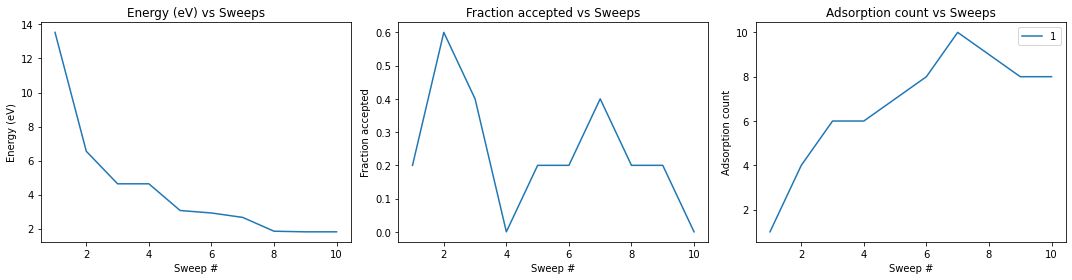

In [11]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [12]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)